In [2]:
import warnings # Omitir mensajes de advertencia
warnings.filterwarnings("ignore")

In [3]:
# Trabajamos en colab: 
from google.colab import drive 
drive.mount('/content/drive/')

import os

path = '/content/drive/MyDrive/Colab Notebooks/OCEANOGRAFIA/BOYA 0N170W/' # Directorio de trabajo

os.chdir(path)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
# %%capture
# !pip install metpy

In [5]:
# %%capture
# #1|Install Conda environment on Colab
# !pip install -q condacolab
# import condacolab
# condacolab.install()
# #2|Install cartopy 
# !mamba install -q -c conda-forge cartopy

In [6]:
import pandas as pd
import xarray as xr 
import matplotlib.pyplot as plt
import numpy as np

In [7]:
sst = xr.open_dataset(path + 'sst.mon.mean.nc')
sst['time'] = pd.date_range('1981-09-01', '2023-06-01', freq = 'M')
sst

<xarray.Dataset>
Dimensions:  (time: 501, lat: 720, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 1981-09-30 1981-10-31 ... 2023-05-31
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    Conventions:    CF-1.5
    title:          NOAA/NCEI 1/4 Degree Daily Optimum Interpolation Sea Surf...
    institution:    NOAA/National Centers for Environmental Information
    source:         NOAA/NCEI https://www.ncei.noaa.gov/data/sea-surface-temp...
    References:     https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2....
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature
    version:        Version 2.1
    comment:        Reynolds, et al.(2007) Daily High-Resolution-Blended Anal...

In [8]:
year_inicio = '1991'
year_fin = '2020'
# Calcular climatología 
clim = sst.sel(time=slice(f'{year_inicio}-01-01', f'{year_fin}-12-31')).groupby('time.month').mean(dim='time')
# Calcular la anomalía 
anom = sst.groupby('time.month') - clim
anom

<xarray.Dataset>
Dimensions:  (time: 501, lat: 720, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 1981-09-30 1981-10-31 ... 2023-05-31
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
    month    (time) int64 9 10 11 12 1 2 3 4 5 6 7 ... 7 8 9 10 11 12 1 2 3 4 5
Data variables:
    sst      (time, lat, lon) float32 nan nan nan ... -0.09194 -0.09194 -0.09194

In [9]:
from scipy.ndimage import gaussian_filter
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [10]:
############################################################################################################
def Hovmoller(datax,sigma):
  fig = plt.figure(figsize=(12, 6))
  # Proporción de las gráficas 
  gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[1, 6], hspace=0.15)  
  #----------------------------------------------------------------------------------------
  # Primera gráfica (Mapa)
  ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=180))
  ax1.set_extent([100, 285, -10, 5], crs=ccrs.PlateCarree())
  ax1.set_yticks([-10, -5, 0, 5])
  ax1.set_xticks([-80,-60,-40,-20,0,20,40,60,80,100])
  ax1.set_xticklabels(['100°E','120°E','140°E','160°E','180°', '160°W', '140°W', '120°W', '100°W','80°W'])
  ax1.grid(linestyle='dotted', linewidth=2)
  #----------------------------------------------------------------------------------------
  ax1.add_feature(cfeature.COASTLINE.with_scale('10m'))
  ax1.add_feature(cfeature.LAKES.with_scale('50m'), color='black', linewidths=0.5)
  ax1.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=1)
  plt.title('Diagrama Hovmöller', style="oblique", fontsize=15, loc='center')
  #----------------------------------------------------------------------------------------
  # Segunda gráfica
  ax2 = fig.add_subplot(gs[1, 0])
  ax2.invert_yaxis()
  levels = np.arange(-4, 5, 0.5)
  sigma = sigma
  interp_temp_smooth = gaussian_filter(datax, sigma=sigma)
  #----------------------------------------------------------------------------------------
  cf = ax2.contourf(datax.lon, datax.time, interp_temp_smooth,levels, cmap='RdBu_r',extend='both')
  # # Definir niveles de las líneas de contorno
  black_levels = [-6,-5,-4,-3,-2,-1.5,-1,0.5,1,2,3,4,4.5,5]
  grey_levels = [level for level in levels if level not in black_levels]
  # Aplicar un suavizado a las líneas de contorno
  cs2 = ax2.contour(datax.lon, datax.time, interp_temp_smooth, levels = black_levels, colors='black',  
                    linewidths=1, linestyles='-')
  cs3 = ax2.contour(datax.lon, datax.time, interp_temp_smooth, levels = grey_levels, colors='whitesmoke',
                    linewidths=0.5, linestyles='--')
  #----------------------------------------------------------------------------------------
  # # Agregar etiquetas a las líneas de contorno
  ax2.clabel(cs2, fmt='%2.1f', colors='black', fontsize=12)
  ax2.set_xlim(100, 282)
  ax2.set_xticks([100, 120,140,160,180,200,220,240,260,280])
  ax2.set_xticklabels(['100°E','120°E','140°E','160°E','180°', '160°W', '140°W', '120°W', '100°W','80°W'])
  #----------------------------------------------------------------------------------------
  # Agregar etiquetas de valores en la barra de colores
  cbar = fig.colorbar(cf, ax=ax2, ticks=np.arange(-4, 5))
  cbar.ax.tick_params(labelsize=10)
  cbar.ax.set_yticklabels(['{:.0f}'.format(i) for i in np.arange(-4, 5)])
  cbar.set_label('Anomalías TSM' ,fontsize = 12)
  #----------------------------------------------------------------------------------------
  # Crear rango de fechas mensuales
  dates = pd.date_range(start=f'{year}-01', end=f'{next_year}-12', freq='2M')
  ax2.set_yticks(dates)
  # # Formatear las fechas
  ax2.set_yticklabels([date.strftime('%Y-%m') for date in dates])
  #----------------------------------------------------------------------------------------
  # Ajustar el largo de la gráfica superior manualmente
  top_plot_height = 0.1  # Ajusta este valor según tus necesidades
  bottom_plot_height = 0.75
  top_plot_position = bottom_plot_height + 0.05  # Espacio entre las gráficas
  # Achicar el extremo derecho de la gráfica superior
  ax1.set_position([0.1245, top_plot_position, 0.621, top_plot_height]) 
  # 0.1245 (ajusta el extremo izquierdo ->), # 0.621 (ajusta el extremo derecho <-)
  plt.grid(axis='y', linestyle = '--',alpha=0.5)
  #----------------------------------------------------------------------------------------
  plt.text(0, -0.13, 'Fuente de datos: OISST V2',  style="oblique", fontsize=12, ha='left', 
        va='center', color='black', transform=plt.gca().transAxes)
    
  fig.savefig(path + f'Hov{year}-{next_year}.jpg', 
                  transparent = False, pad_inches = 0.1, dpi = 900, bbox_inches = 'tight')    
  #----------------------------------------------------------------------------------------  
  plt.show()
  plt.close()  

# EVENTOS NIÑO: 
1. 1982 (7) - 1983 (11)  (Extraordinario) 
2. 1997 (3) - 1998 (9) (Extraordinario) 

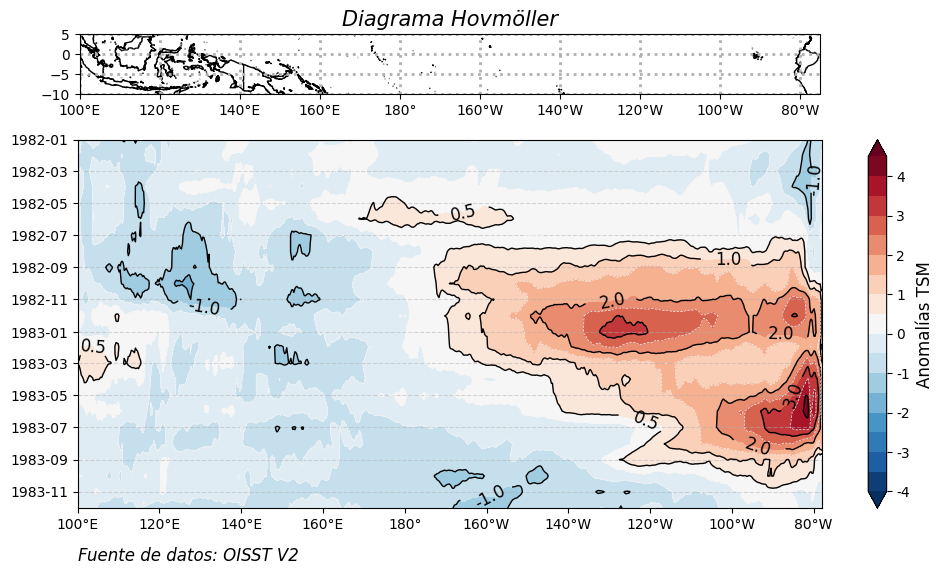

In [11]:
years = [1982,1983]
for i in range(len(years)-1):
  year = years[i]
  next_year = years[i+1]  
  Hovmoller(anom['sst'].sel(time=slice(f'{year}-01-01',f'{next_year}-12-31')).sel(lat=slice(-10,5)).sel(lon=slice(0,360)).mean(dim='lat'), 0)

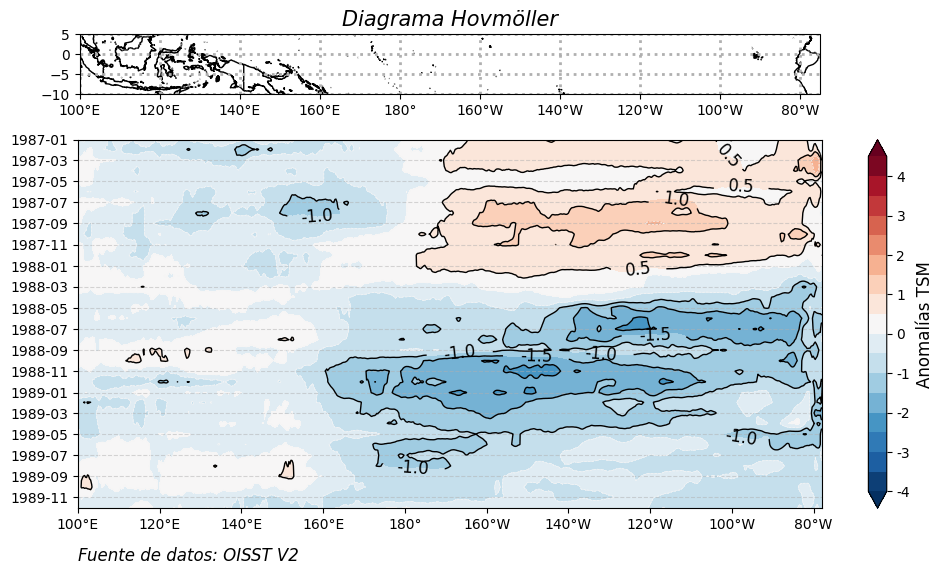

In [ ]:
years = [1987,1989]
for i in range(len(years)-1):
  year = years[i]
  next_year = years[i+1]  
  Hovmoller(anom['sst'].sel(time=slice(f'{year}-01-01',f'{next_year}-12-31')).sel(lat=slice(-10,5)).sel(lon=slice(0,360)).mean(dim='lat'), 0)

# EVENTOS NIÑA: 
1. 1988 (5) - 1988 (10) (Fuerte) 
2. 2007 (5) - 2007 (12) (Fuerte) 


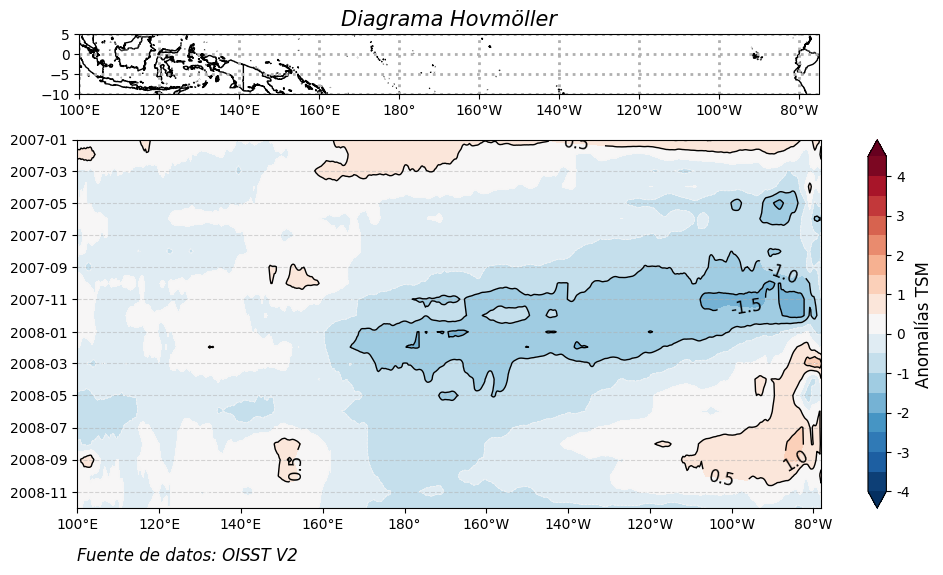

In [ ]:
years = [2007,2008]
for i in range(len(years)-1):
  year = years[i]
  next_year = years[i+1]  
  Hovmoller(anom['sst'].sel(time=slice(f'{year}-01-01',f'{next_year}-12-31')).sel(lat=slice(-10,5)).sel(lon=slice(0,360)).mean(dim='lat'), 0)